# AI-based OCR Benchmark Notebook

This notebook benchmarks **AI-based OCR models** on scanned PDF documents/images in Spanish.
It excludes traditional OCR engines like Tesseract that require external installations.

In [ ]:
%pip install --upgrade pip
%pip install --upgrade jupyter
%pip install --upgrade ipywidgets
%pip install --upgrade ipykernel

# Install necessary packages
%pip install easyocr transformers torch pdf2image pillow jiwer paddleocr hf_xet paddlepaddle
# pdf reading
%pip install PyMuPDF

# Data analysis and visualization
%pip install pandas
%pip install matplotlib
%pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https:/

In [11]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image, ImageOps
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from jiwer import wer, cer
from paddleocr import PaddleOCR
import fitz  # PyMuPDF

## 1 Configuration

In [4]:
PDF_FOLDER = './instructions'  # Folder containing PDF files
OUTPUT_FOLDER = 'results'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [5]:
# 1. EasyOCR (works well already)
import easyocr
easyocr_reader = easyocr.Reader(['es', 'en'])  # Spanish and English

# 2. TrOCR - Use a better variant for documents
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Try using the large model for better performance
try:
    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")
except:
    # Fallback to base model
    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trocr_model = trocr_model.to(device)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 3. PaddleOCR - Better configuration
from paddleocr import PaddleOCR

# Initialize with better settings for Spanish/Latin text
paddleocr_model = PaddleOCR(
    lang='es',  # Use 'latin' for better Spanish support
    det_db_thresh=0.3,  # Lower threshold for better text detection
    det_db_box_thresh=0.5,
    rec_batch_num=6,
)


C:\Users\sji\AppData\Local\Temp\ipykernel_35244\1485176348.py:5: DeprecationWarning: The parameter `det_db_thresh` has been deprecated and will be removed in the future. Please use `text_det_thresh` instead.
  paddleocr_model = PaddleOCR(
C:\Users\sji\AppData\Local\Temp\ipykernel_35244\1485176348.py:5: DeprecationWarning: The parameter `det_db_box_thresh` has been deprecated and will be removed in the future. Please use `text_det_box_thresh` instead.
  paddleocr_model = PaddleOCR(
C:\Users\sji\AppData\Local\Temp\ipykernel_35244\1485176348.py:5: DeprecationWarning: The parameter `rec_batch_num` has been deprecated and will be removed in the future. Please use `text_recognition_batch_size` instead.
  paddleocr_model = PaddleOCR(
c:\Users\sji\Desktop\MastersThesis\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github

## 2 Helper Functions

In [ ]:
from typing import List, Optional

def show_ocr_result(img: Image.Image, text: str,  scale: float = 0.20):
    """
    Displays a smaller version of the image with OCR text as a footer.
    """
    # Compute plot size based on image dimensions (but without resizing the image)
    w, h = img.size
    figsize = (w * scale / 100, h * scale / 100)  # convert pixels to inches approx

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.axis("off")


    # Add OCR text below the image (footer)
    plt.figtext(0.5, 0.02, text.strip(), wrap=True, ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def pdf_to_images(pdf_path: str, dpi: int = 300, pages: List[int] = None) -> List[Image.Image]:
    """Render a PDF into a list of PIL Images using PyMuPDF or pdf2image."""
    images = []
    if fitz is not None:
        doc = fitz.open(pdf_path)
        page_indices = pages if pages is not None else list(range(len(doc)))
        for i in page_indices:
            page = doc.load_page(i)
            mat = fitz.Matrix(dpi/72.0, dpi/72.0)
            pix = page.get_pixmap(matrix=mat, alpha=False)
            img = Image.frombytes('RGB', [pix.width, pix.height], pix.samples)
            images.append(img)
        doc.close()
    elif convert_from_path is not None:
        if pages is None:
            images = convert_from_path(pdf_path, dpi=dpi)
        else:
            # pdf2image supports first_page/last_page; render a slice if contiguous
            images = [convert_from_path(pdf_path, dpi=dpi)[i] for i in pages]
    else:
        raise RuntimeError('Install PyMuPDF or pdf2image to convert PDFs.')
    return images

def ocr_easyocr(img):
    result = easyocr_reader.readtext(np.array(img))
    res = ' '.join([r[1] for r in result])
    show_ocr_result(img, res)
    return res

def pdf_extract_text(pdf_path, page_num) -> str:
    """
    Extracts text from a specific PDF page in proper reading order.
    """
    doc = fitz.open(pdf_path)
    
    if page_num < 1 or page_num > len(doc):
        return ""
    
    page = doc[page_num - 1]
    blocks = page.get_text("blocks")  # returns list of (x0, y0, x1, y1, "text", block_no, block_type)
    
    # Sort blocks top-to-bottom, left-to-right
    blocks_sorted = sorted(blocks, key=lambda b: (b[1], b[0]))  # y0, then x0
    
    text = " ".join([b[4].replace('\n', ' ').strip() for b in blocks_sorted])
    return text

def evaluate_text(reference, prediction):
    return {'WER': wer(reference, prediction), 'CER': cer(reference, prediction)}

## 3 Run AI OCR Benchmark

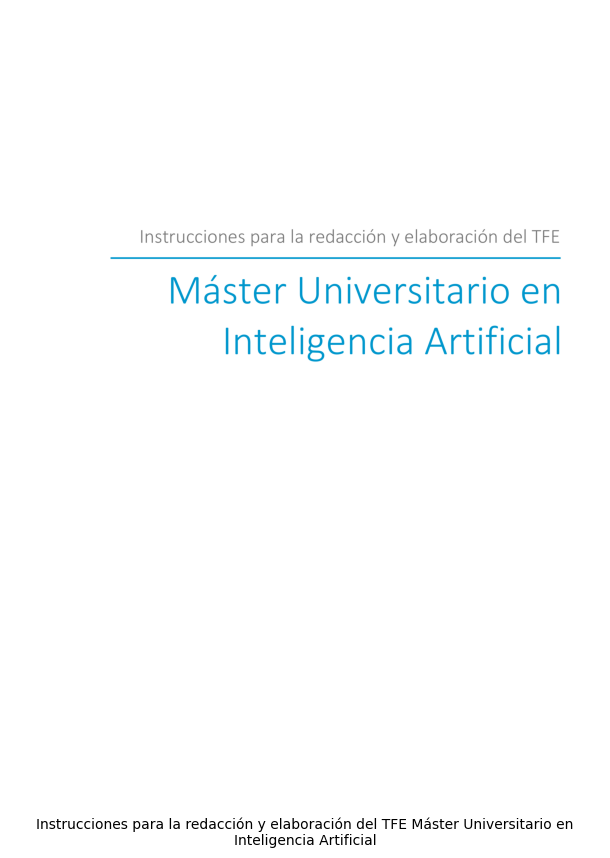

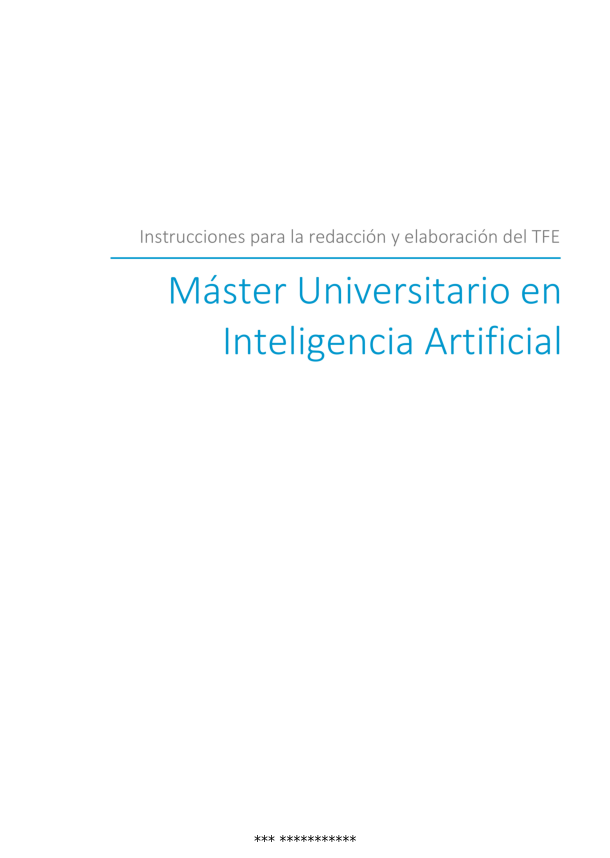

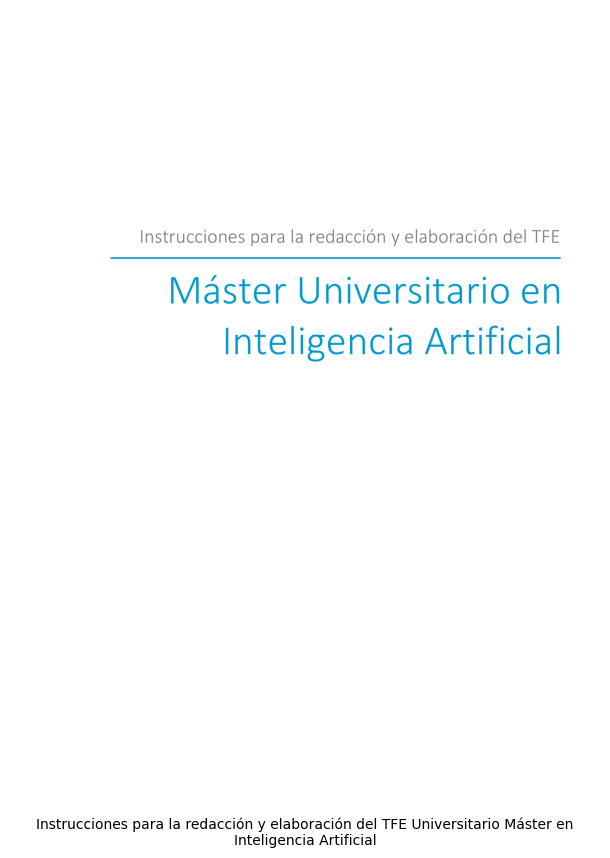

In [ ]:

def ocr_trocr(img):
    """
    Fixed TrOCR function for better text recognition
    """
    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Process the image - TrOCR expects RGB input
    pixel_values = trocr_processor(images=img, return_tensors="pt").pixel_values.to(device)
    
    # Generate text with optimized parameters
    with torch.no_grad():
        generated_ids = trocr_model.generate(
            pixel_values,
            max_new_tokens=200,  # Allow sufficient tokens
            num_beams=4,  # Beam search for better quality
            early_stopping=True,
            no_repeat_ngram_size=2,  # Prevent repetitions
            length_penalty=1.0,
            do_sample=False  # Deterministic output
        )
    
    # Decode the generated text
    generated_text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Show result
    show_ocr_result(img, generated_text)
    
    return generated_text


def ocr_paddle(img):
    """
    Fixed PaddleOCR function using the correct API
    """
    # Convert PIL image to numpy array
    img_array = np.array(img)
    result = paddleocr_model.predict(img_array)
    # Extract text from result
    text_list = []
    breakpoint()
    items = []
    for item in result:
        boxes = item.json["res"]["rec_boxes"]
        texts = item.json["res"]["rec_texts"]        
        for box, text in zip(boxes, texts):
            x1, y1, _, _ = box
            items.append((x1, y1, text))
    
    # line_tolerance=40
    # Sort top-to-bottom (with tolerance), then left-to-right
    # items.sort(key=lambda t: (round(t[1] / line_tolerance), t[0]))

    # Extract ordered text
    ordered_texts = [t[2] for t in items]
    res = " ".join(ordered_texts)
    
    show_ocr_result(img, res)
    
    return res


results = []

for pdf_file in os.listdir(PDF_FOLDER):
    if not pdf_file.lower().endswith('.pdf'):
        continue
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    images = pdf_to_images(pdf_path)
    
    for i, img in enumerate(images):
        if i != 0:
            break
        page_num = i+1
        ref = pdf_extract_text(pdf_path, page_num=page_num)
        
        # EasyOCR
        easy_text = ocr_easyocr(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'EasyOCR', 'Prediction': easy_text, **evaluate_text(ref, easy_text)})
        
        # TrOCR
        trocr_text = ocr_trocr(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'TrOCR', 'Prediction': trocr_text, **evaluate_text(ref, trocr_text)})
        
        # PaddleOCR
        paddle_text = ocr_paddle(img)
        results.append({'PDF': pdf_file, 'Page': page_num, 'Model': 'PaddleOCR', 'Prediction': paddle_text, **evaluate_text(ref, paddle_text)})

## 4 Save and Analyze Results

Benchmark results saved!
                WER       CER
Model                        
EasyOCR    0.000000  0.000000
PaddleOCR  0.153846  0.138614
TrOCR      1.000000  0.990099


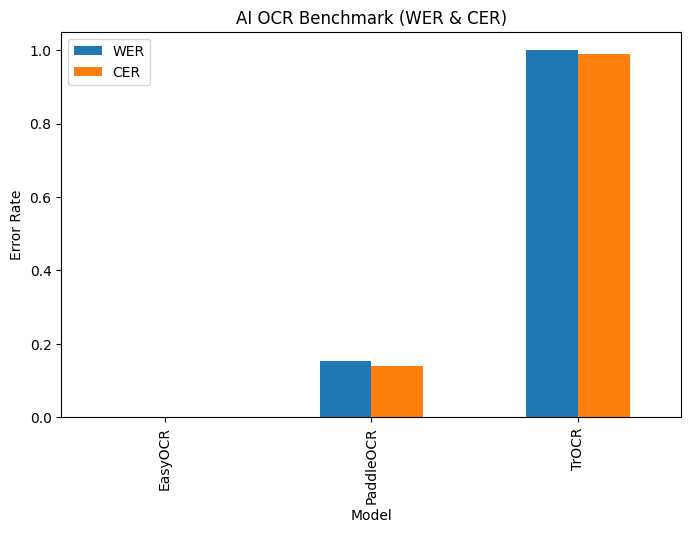

In [31]:
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_FOLDER, 'ai_ocr_benchmark_results.csv'), index=False)
print('Benchmark results saved!')

# Summary by model
summary = df_results.groupby('Model')[['WER', 'CER']].mean()
print(summary)

# Plot
summary.plot(kind='bar', figsize=(8,5), title='AI OCR Benchmark (WER & CER)')
plt.ylabel('Error Rate')
plt.show()